# 2. Exploratory Data Analysis

Lets explore the data to better understand its characteristics. For this analysis, we will use the data prepared previously.

As first step lets import the dataset

## 2.1 Import prepared dataset

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats


df_final = pd.read_csv('../data/final_data_2010_2021.csv')
df_final['DATETIME'] = pd.to_datetime(df_final['DATETIME'], format='%Y-%m-%d  %H:%M:%S')
df_final.drop(df_final[df_final['DATETIME'].dt.date >= dt.date(2021, 1, 1)].index, inplace = True)
df_final.set_index('DATETIME', inplace=True)
print(df_final)

                     TOTALDEMAND  TEMPERATURE  HOLIDAY  SUMMER  AUTUMN  \
DATETIME                                                                 
2010-01-01 00:00:00      8038.00         23.1        1       1       0   
2010-01-01 00:30:00      7809.31         22.9        1       1       0   
2010-01-01 01:00:00      7483.69         22.6        1       1       0   
2010-01-01 01:30:00      7117.23         22.5        1       1       0   
2010-01-01 02:00:00      6812.03         22.5        1       1       0   
...                          ...          ...      ...     ...     ...   
2020-12-31 21:30:00      7072.75         20.1        0       1       0   
2020-12-31 22:00:00      7062.97         19.9        0       1       0   
2020-12-31 22:30:00      7172.60         19.6        0       1       0   
2020-12-31 23:00:00      7125.65         19.3        0       1       0   
2020-12-31 23:30:00      7080.04         19.6        0       1       0   

                     WINTER  SPRING  

## 2.2 Detail Data Analysis

### 2.2.1 Yearly demand 
 
Analysis of the electricity demand over the years would help identify historic trends and any seasonal effects. As a start, lets review average, Minimum and Maximum demand fluctuation over the years.

It is evident that the the averge demand has reduced or flat lined over the years. This is an interesting finding as we would expect the demand to rise with the population increase over the years. Therefore, it would be prudent to limit the dataset to the latest for model build considering our research question. The minimum and maximum demand seem to fluctuate within a range and does not indicate any significant trends.

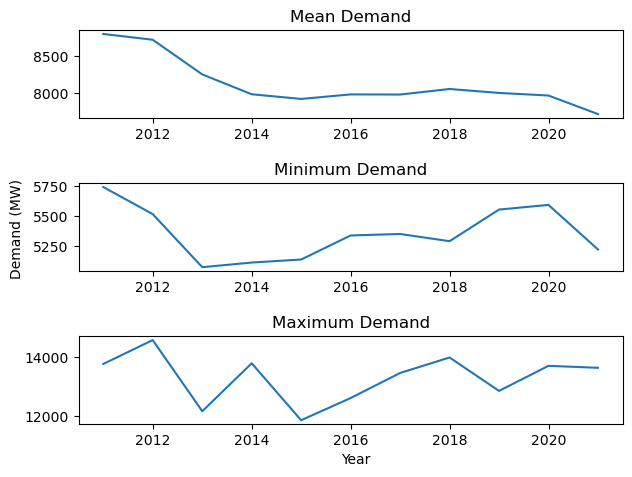

In [2]:
fig, axis = plt.subplots(3)#, sharex=True)

year_mean = df_final.resample('Y')['TOTALDEMAND'].mean()
year_max = df_final.resample('Y')['TOTALDEMAND'].max()
year_min = df_final.resample('Y')['TOTALDEMAND'].min()

#print(year_mean)
axis[0].plot(year_mean)
axis[1].plot(year_min)
axis[2].plot(year_max)
axis[0].set_title("Mean Demand")
axis[1].set_title("Minimum Demand")
axis[2].set_title("Maximum Demand")

fig.text(0.55, 0.01, 'Year', ha='center')
fig.text(0.01, 0.5, 'Demand (MW)', va='center', rotation='vertical')
fig.tight_layout(pad=1.5)

<i> Note: A potential reason for decrease in demand could be the increase use of roof top solar panels. Below graph from Australian PV Institute https://pv-map.apvi.org.au/analyses shows a clear increase of Solar panel installations. Howeve further research is required to confirm any relationship. </i>

<img src="AusPVInst.PNG" width="500" height="340"> 

### 2.2.2  Decompose Time series

Electricity demand data is of time series nature. According to Australian Energy market operator (AEMO), Time series models are more applicable in short-term forecasting which relates to our research question. (Refer section 2.4 in https://aemo.com.au/-/media/files/electricity/nem/planning_and_forecasting/nem_esoo/2023/forecasting-approach_electricity-demand-forecasting-methodology_final.pdf)


Time series data can be decomposed to four components. (https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/) 

These components are defined as follows:

* Level - The average value in the series.
* Trend - The increasing or decreasing value in the series.
* Seasonality - The repeating short-term cycle in the series.
* Noise - The random variation in the series.

The Level and Trend plots both show gradual decline in demand. The seasonal plot shows the peaks and troughs in a repetitive pattern. We need further analysis to understand the underlying reasons.

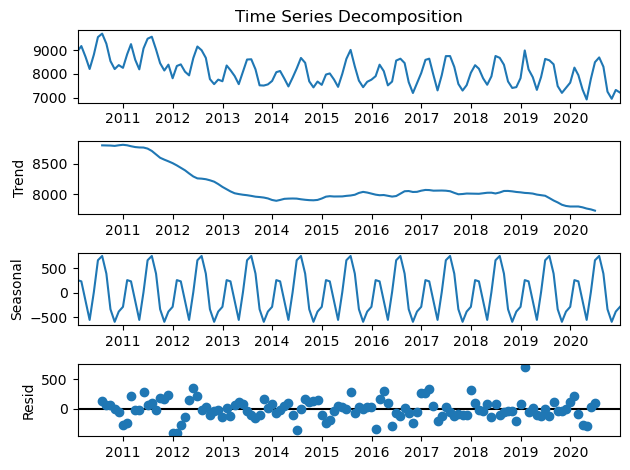

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_tmp = df_final['TOTALDEMAND'].copy().resample('M').mean()
df_tmp.name = 'Time Series Decomposition'

df_rslt = seasonal_decompose(df_tmp, model='additive')
df_rslt.plot()
plt.show()


Further, to verify that the data set used is suitable for time series analysis we perform a stationarity test using ADF (Augmented Dickey-Fuller).

The null(H0) and alternate hypothesis(H1) of ADF test are:

* H0: The series has a unit root (value of a=1),the series is non-stationary.
* H1: The series has no unit root, the series is stationary.

If we cannot reject the null hypothesis, we can say that the series is not stationary, and if we do, it is stationary.

Based on the results we can observe that the test statistic is lower than the critical values. Therefore we could reject the null hypothesis and conclude that the time series is stationary.

In [12]:
from statsmodels.tsa.stattools import adfuller

df_temp = adfuller(df_final['TOTALDEMAND'].resample('D').mean(), autolag='AIC')
df_rslt = pd.Series(df_temp[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_temp[4].items():
   df_rslt['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller Test:')
print (df_rslt)

Results of Dickey-Fuller Test:
Test Statistic                   -5.586991
p-value                           0.000001
#Lags Used                       28.000000
Number of Observations Used    3989.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862265
Critical Value (10%)             -2.567156
dtype: float64


### 2.2.2 Monthly Demand

Lets analyse the impact of demand based on the month. We tend to use heating during winter months and cooling during summer. The heatmap clearly indicates that June, July, August winter months and January, February Summer months have a higher average demand for electricity. Conversely Spring and Autumn has a lower average demand. Therefore the month/season should be considered for the model build.

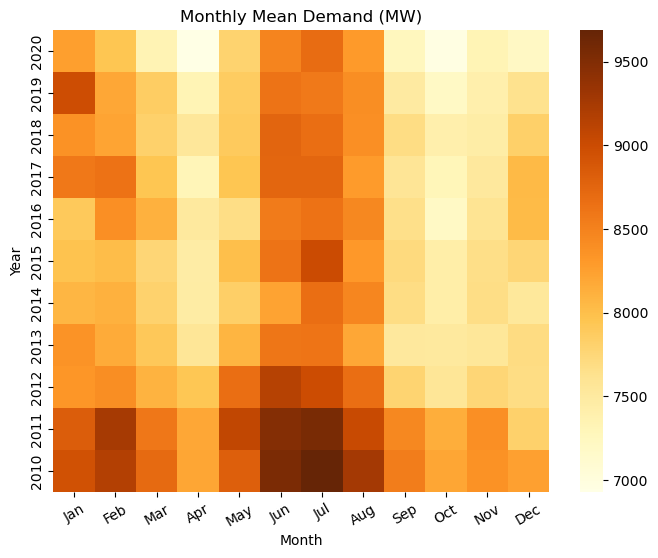

In [30]:
#create a dataframe for monthly demand
df_md = df_final.copy()
#add year column
df_md['YEAR'] = df_md.index.year

# Create a Pivot Table where Mean demand is calculated with Year, Month)
hm_pt = pd.pivot_table(df_md,values ='TOTALDEMAND', index=['YEAR'], columns='MONTH', aggfunc='mean')
# Plot the Heatmap
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(hm_pt, cmap="YlOrBr")
plt.xticks(rotation=30)
ax.set_xlabel("Month")
ax.set_ylabel("Year")
ax.invert_yaxis()
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Monthly Mean Demand (MW)')
plt.show()

### 2.2.3 Day of the week Demand

Next we analyse whether the demand fluctuate depending on the day of the week. As per the heatmap, weekends tend to have lower demand. This could be due to the fact that most offices, factories are closed during the weekend. Also, many people tend to spend weekends outside. Similar to month, day of the week seems to have an influence on the demand. Hence suitable to be included in the model build.

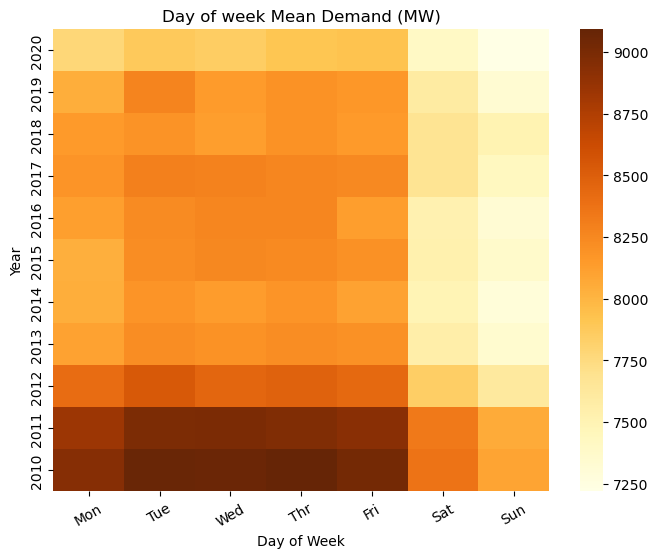

In [31]:
#create a dataframe for day of week demand
df_dow = df_final.copy()
#add year column
df_dow['YEAR'] = df_dow.index.year

# Create a Pivot Table where Mean demand is calculated with Year, Month)
hm_pt = pd.pivot_table(df_dow,values ='TOTALDEMAND', index=['YEAR'], columns='DAYOFWEEK', aggfunc='mean')

# Plot the Heatmap
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(hm_pt, cmap="YlOrBr")
plt.xticks(rotation=30)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Year")
ax.invert_yaxis()
ax.set_xticklabels(['Mon','Tue','Wed','Thr','Fri','Sat','Sun'])
ax.set_title('Day of week Mean Demand (MW)')
plt.show()

### 2.2.4 Holiday Demand

Extending on the day of the week demand, we would like to analyse the difference in average demand between holidays and non-holidays.
For this we consider Public holidays and Weekends as "Holidays" and all the other days as non-holidays.

The graph clearly indicate a significant difference in mean demand between holidays and non-holidays. As noted previously for Saturday and Sunday, this may be due the fact that offices, factories not operating over holidays resulting in lower demand. Therefore we could conclude that holidays has a impact on the overall demand and therefore should be considered in the model.

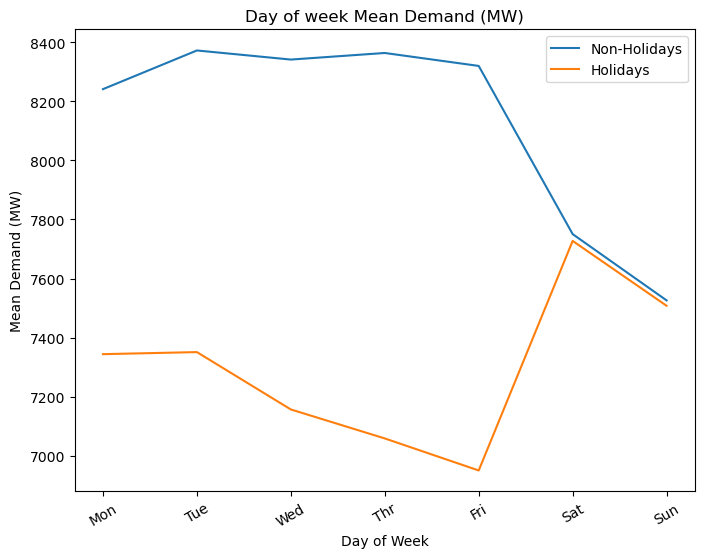

In [32]:
fig, ax = plt.subplots(figsize=(8,6))

rslt_df0 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[(df_final['HOLIDAY'] == 0) | (df_final['DAYOFWEEK'] < 5)]
rslt_df1 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[(df_final['HOLIDAY'] == 1) | (df_final['DAYOFWEEK'] > 4)]

ax.plot(rslt_df0.groupby('DAYOFWEEK').mean())
ax.plot(rslt_df1.groupby('DAYOFWEEK').mean())

dow = ('Mon','Tue','Wed','Thr','Fri','Sat','Sun')
plt.xticks(rotation=30)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Mean Demand (MW)")

ax.set_xticks(np.arange(0, 7, 1), dow)
ax.set_title('Day of week Mean Demand (MW)')
plt.legend(["Non-Holidays", "Holidays"])
plt.show()

### 2.2.5 Hour of the Day Demand

At the next granular level, we would like to observe how demand fluctuates within a day (hour by hour). Australian energy providers broadly segregates hourly demand to three groups (https://www.canstarblue.com.au/electricity/peak-off-peak-electricity-times/). Peak, off-peak and shoulder. There are variations of this by providers. For our analysis purposes, we would simplify to Peak and Off-peak only. As evident from the graph, approx from 7:00 AM to 10:00 PM, the demand seems to be high. Therefore we would use that period as Peak demand and rest as off-peak demand for our model build.

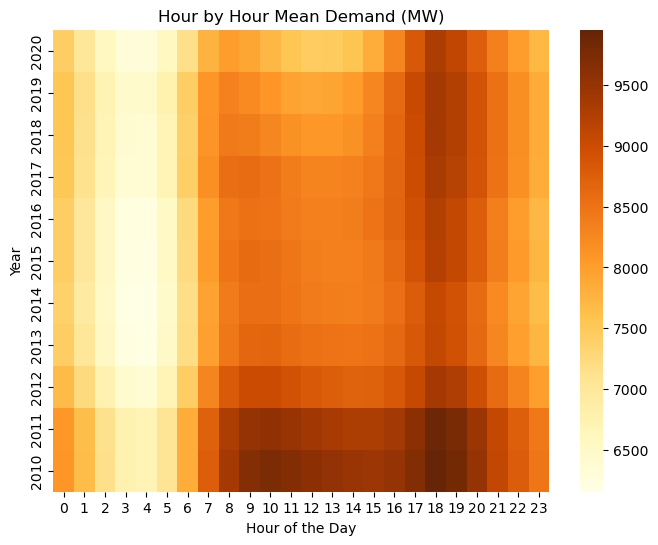

In [33]:
#create a dataframe for day of week demand
df_hd = df_final.copy()
#add year column
df_hd['YEAR'] = df_hd.index.year

# Create a Pivot Table where Mean demand is calculated with Year, Month)
hm_pt = pd.pivot_table(df_hd,values ='TOTALDEMAND', index=['YEAR'], columns='HOUR', aggfunc='mean')

# Plot the Heatmap
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(hm_pt, cmap="YlOrBr")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Year")
ax.invert_yaxis()
ax.set_title('Hour by Hour Mean Demand (MW)')
plt.show()

### 2.2.6 Peak vs Off-peak demand

Based on previous analysis, lets verify the variations in demand based on Peak hours vs off-peak. Additionally, we further drill-down on holidays vs non-holidays. The graphs clearly indicate the difference in demand between peak and off-peak hours. This pattern is visible both during non-holidays and holidays. Therefore we should consider Peak/Off-Peak demand in the model build.

Text(0.01, 0.5, 'Demand (MW)')

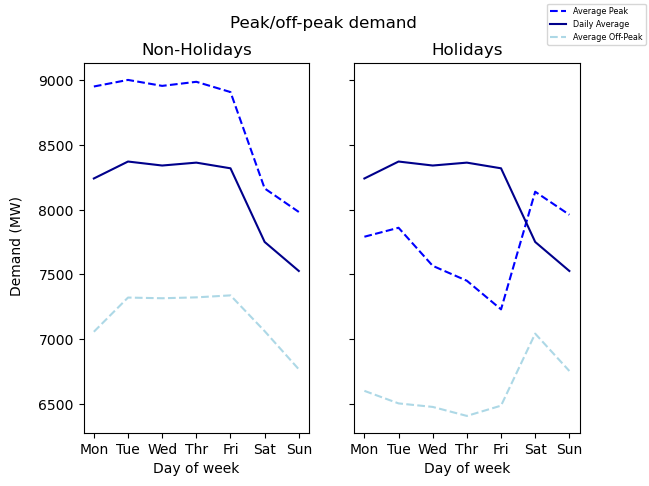

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True)

rslt_df0 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[((df_final['HOLIDAY'] == 0) | (df_final['DAYOFWEEK'] < 5)) & (df_final['PEAK']==1)]
rslt_df1 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[((df_final['HOLIDAY'] == 0) | (df_final['DAYOFWEEK'] < 5))]
rslt_df2 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[((df_final['HOLIDAY'] == 0) | (df_final['DAYOFWEEK'] < 5)) & (df_final['PEAK']==0)]
rslt_df3 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[((df_final['HOLIDAY'] == 1) | (df_final['DAYOFWEEK'] > 4)) & (df_final['PEAK']==1)]
rslt_df4 = df_final[['DAYOFWEEK','TOTALDEMAND']].loc[((df_final['HOLIDAY'] == 1) | (df_final['DAYOFWEEK'] > 4)) & (df_final['PEAK']==0)]

dow = ('Mon','Tue','Wed','Thr','Fri','Sat','Sun')
ax1.plot(rslt_df0.groupby('DAYOFWEEK').mean(), color='blue', linestyle='--')
ax1.plot(rslt_df1.groupby('DAYOFWEEK').mean(), color='darkblue')
ax1.plot(rslt_df2.groupby('DAYOFWEEK').mean(), color='lightblue', linestyle='--')
ax1.set_xticks(np.arange(0, 7, 1), dow)
ax1.set_xlabel("Day of week")

ax2.plot(rslt_df3.groupby('DAYOFWEEK').mean(), color='blue', linestyle='--')
ax2.plot(rslt_df1.groupby('DAYOFWEEK').mean(), color='darkblue')
ax2.plot(rslt_df4.groupby('DAYOFWEEK').mean(), color='lightblue', linestyle='--')
ax2.set_xlabel("Day of week")
ax2.set_xticks(np.arange(0, 7, 1), dow)

ax1.set_title("Non-Holidays")
ax2.set_title("Holidays")

fig.suptitle('Peak/off-peak demand')
fig.legend(['Average Peak','Daily Average','Average Off-Peak'], loc='upper right', fontsize='xx-small')
fig.text(0.01, 0.5, 'Demand (MW)', va='center', rotation='vertical')



### 2.2.7 Autocorrelation & Lag

We would like to understand the influence of Lag in the chosen model. Prior to that lets review the concept. 

Autocorrelation (serial correlation) is correlation between two values of the same variable at times $$t$$ and $$t-k$$.
When a value from a time series is regressed on previous values from that same time series, it is referred to as an autoregressive model. e.g $$y_t$$ and $$y_ (t-1)$$

$$ y_t = \beta_0 + \beta_1y_t-1 + \epsilon_t$$

The above is a first order autoregressive model. Meaning only one proceeding value is used to predictor variable and is written as AR(1). If we used two previous values as predictors, then it would be a second order autoregressive model i.e. AR(2). This can be generalised as AR(k), i.e kth order autoregressive model.

The autocorrelation function (ACF) is given as,

$$Corr(y_t,y_t-k) ),k=1,2,..n$$ where k is the time gap or the lag between values of the same variable.
We are interested in Partial Autocorrelation, which measure the association between yt and yt−k directly and filter out the linear influence of the random variables that lie in-between. PACF is useful to identify the order of autocorrelation.

The ACF plot seems to indicate cyclical pattern and this could be due to seasononality effect on the demand data. It also seem to highlight high correlation between adjacent data points. 

The PACF graph shows significant spike in lag 1,2 and 3 but seems to decay as it moves along. Hence it maybe useful to limit to 3 lags for the model.

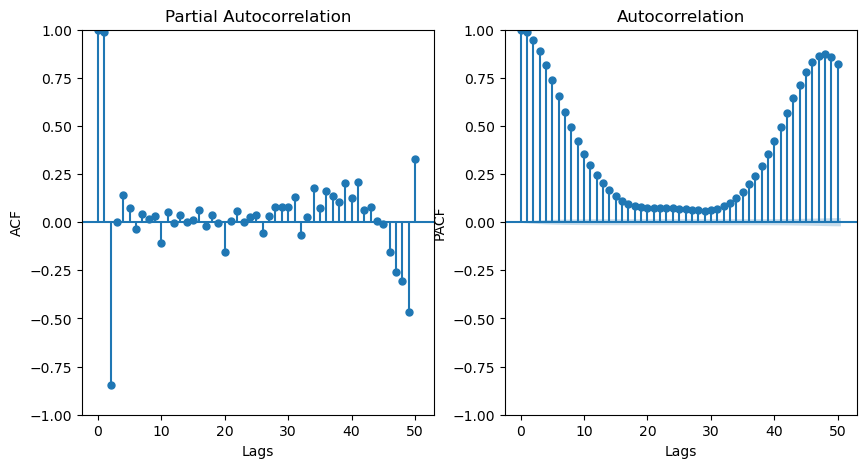

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_tmp = df_final[['TEMPERATURE','TOTALDEMAND']].copy()

fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_pacf(df_tmp['TOTALDEMAND'], lags=50, ax=ax[0], alpha=0.05, method="ywm")
plot_acf(df_tmp['TOTALDEMAND'], lags=50, ax=ax[1], alpha=0.05)
ax[0].set_xlabel('Lags')
ax[1].set_xlabel('Lags')
ax[0].set_ylabel('ACF')
ax[1].set_ylabel('PACF')
plt.show()

### 2.2.8 Distibution of Total Demand

We use the Kernal density estimate (KDE) plot to understand the distribution of Total demand. The plot display a normal distribution. Note that the plot use logarithmic scale to ensure graph is made more readable/intuitive whilst ironing out some of the outliers or extreme values.

To further confirm that the underlying distribution, we draw a Q-Q plot with assumed distribution as 'Normal'. The data points follow a straight line in the Q-Q plot (except a slight deviation at the start and end). This confirms that the dataset is consistent with the assumed distribution.

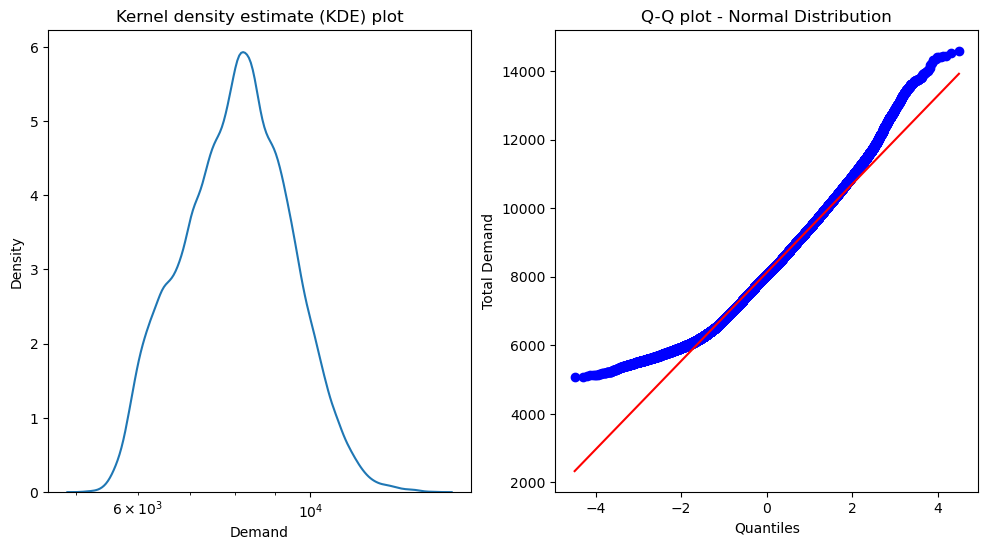

In [27]:
df_tmp = df_final[['TOTALDEMAND']].copy()

fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.kdeplot(data=df_tmp, x="TOTALDEMAND", log_scale=True, ax=ax[0])

stats.probplot(df_final['TOTALDEMAND'], dist="norm", plot=ax[1])
ax[0].set_title('Kernel density estimate (KDE) plot')
ax[0].set_xlabel('Demand')
ax[0].set_ylabel('Density')

ax[1].set_title('Q-Q plot - Normal Distribution')
ax[1].set_xlabel('Quantiles')
ax[1].set_ylabel('Total Demand')
plt.show()

### 2.2.9 Temperature and demand relationship

The relationship between temperature and electricity demand is well known. As the temperature increase, it is clearly evident that demand increases. However it is interesting to note that when temperature decreases, especially below 10 degrees, we see a limited spike in demand. Potential reason could be that in NSW temperature falls mostly during the night / early morning and therefore consumers do not necessarly need heating. However the high temperatures are mostly during day time and as a result people use air conditioning. This explains the reason for high demand. 

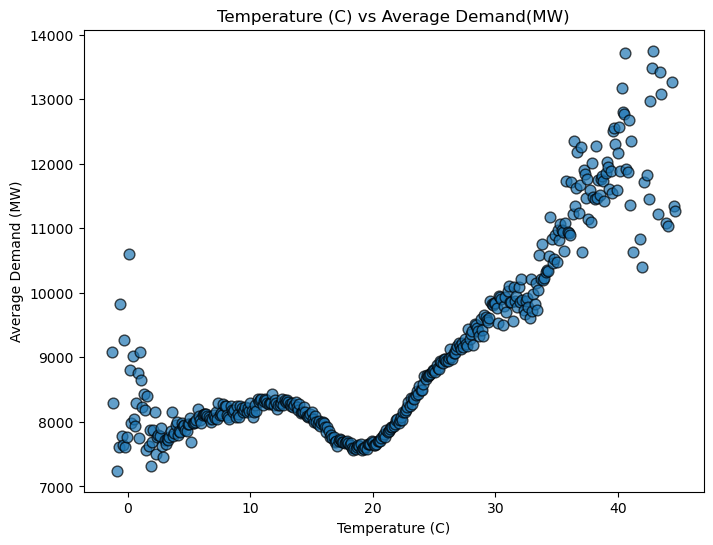

In [28]:
df_tmp = df_final[['TEMPERATURE','TOTALDEMAND']].copy()
df_tmp.reset_index(drop=True, inplace=True)
df_tmp = df_tmp.groupby('TEMPERATURE').mean().reset_index()

fig, ax = plt.subplots(figsize=(8,6))
x = df_tmp['TEMPERATURE']
y = df_tmp['TOTALDEMAND']
ax.scatter(x, y, s=60, alpha=0.7, edgecolors="k")
ax.set_xlabel("Temperature (C)")
ax.set_ylabel("Average Demand (MW)")
ax.set_title('Temperature (C) vs Average Demand(MW)')
plt.show()

### 2.2.10 Correlation matrix

SignificanceResult(statistic=0.5722519777496977, pvalue=0.0)


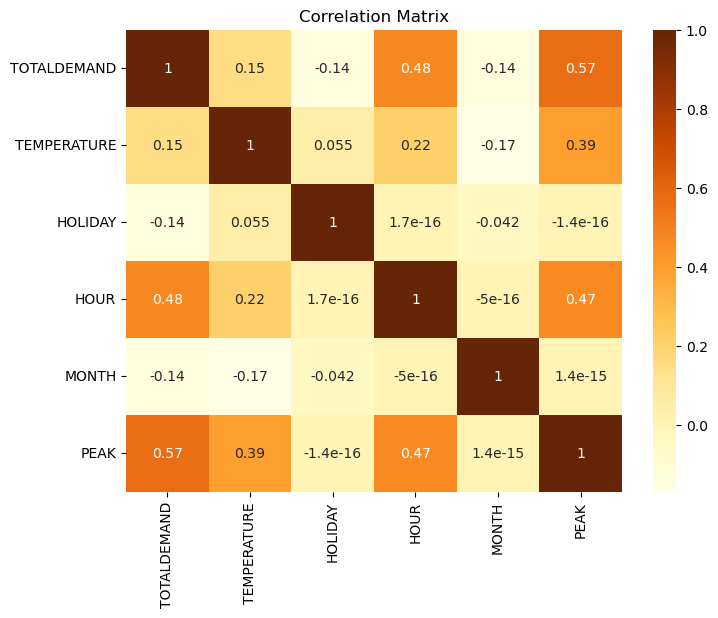

In [35]:
import statsmodels.api

#print(df_final)
df_tmp = df_final[['TOTALDEMAND','TEMPERATURE','HOLIDAY','HOUR','MONTH','PEAK']].copy()
#df_tmp['HOUR'] = np.sin(2*np.pi*df_tmp['HOUR']/24)

print(stats.pointbiserialr(df_tmp['PEAK'], df_tmp['TOTALDEMAND']))

#df_tmp.reset_index(drop=True, inplace=True)
#df_tmp = df_tmp.groupby('TEMPERATURE').mean().reset_index()


fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_tmp.corr(), annot=True, cmap="YlOrBr")
plt.title('Correlation Matrix')
plt.show()